# <b> CSCI 580 Artifical Intelligence: Final Report

<p> This report documents our model for handwritten digit recognition. Specifically, it will cover various attributes of our model and its overall performance. The people in our team who worked on the project are <b> Harsh Sharma, Marco U Calderon, Luis Manuel Melgoza, and Kamaldeep Singh </b>

Here is a link to a GitHub repository including all relevant materials:  (https://github.com/HarshTheSharma/Final580). Also make sure to import these modules: </p>

In [1]:
import os
import glob
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from sklearn.metrics import classification_report, confusion_matrix

<br>

## <b> Our Model's Framework

<p> A high-level framework for our solution involves using a Multilayer Perceptron (MLP), which is a fully connected feedforward neural network. This framework is implemented using PyTorch and is designed to classify 28 x 28 grayscale handwritten digit images from the MNIST and team-collected datasets.

Regarding details about our Neural Net architecture, we have exactly four linear layers: three hidden layers and one output layer. Our model starts with hundreds of neurons that gradually decrease in number as we progress through each layer. We end up with ten neurons in our output layer, corresponding to the 10 digit classes. The total number of weights excluding Batch Norm parameters is around 566,528. Furthermore, our model also uses the Rectified Linear Unit (ReLU) activation function after each hidden layer’s batch normalization, which stabilizes training alongside dropout in the first two hidden layers to avoid overfitting.

In addition to our Neural Net architecture, our model is driven by carefully tuned hyperparameters. The model uses the Adam optimizer to update weights with the standard cross-entropy loss function for multi-class classification. Its initial learning rate is set to 0.0005, with L2 regularization (weight decay) of 0.0001 to reduce overfitting. Additionally, a Reduce Learning Rate on Plateau is included, which halves the learning rate if the validation loss plateaus for consecutive epochs. Speaking of epochs, we are doing 100 epochs on the MNIST dataset, and handwritten digits made by 10 groups with 4 members each.
</p>

## <b> Detailed Aspects of Our Solution

## Part 1: Data & Augmentation Setup

<p>The first major part of our implementation concerns data and augmentation setup. To maximize our model's performance, we apply various transformations to the images, so our model can pick up on varying image types. Here is all of our transformations: </p>

In [2]:
class RaiseDarkPoint(object):
    def __init__(self, grayRange=(10, 60)):
        self.grayRange = grayRange

    def __call__(self, img):
        arr = np.array(img).astype(np.float32)
        grayVal = np.random.uniform(*self.grayRange)
        mask = arr < 30
        arr[mask] = arr[mask] + grayVal
        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8), mode="L")


class LowerWhitePoint(object):
    def __init__(self, factorRange=(0.7, 0.95)):
        self.factorRange = factorRange

    def __call__(self, img):
        arr = np.array(img, dtype=np.float32)
        factor = float(np.random.uniform(self.factorRange[0], self.factorRange[1]))
        arr = arr * factor
        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8), mode="L")


class AddNoise(object):
    def __init__(self, noiseStd=0.05):
        self.noiseStd = noiseStd

    def __call__(self, img):
        arr = np.array(img).astype(np.float32)
        noise = np.random.normal(0, self.noiseStd * 255, arr.shape)
        arr = arr + noise
        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8), mode="L")


class BubblyDigits(object):
    def __init__(self, blurRange=(0.4, 1.0), contrastRange=(1.1, 1.6)):
        self.blurRange = blurRange
        self.contrastRange = contrastRange

    def __call__(self, img):
        sigma = float(np.random.uniform(self.blurRange[0], self.blurRange[1]))
        img = img.filter(ImageFilter.GaussianBlur(radius=sigma))
        c = float(np.random.uniform(self.contrastRange[0], self.contrastRange[1]))
        img = ImageEnhance.Contrast(img).enhance(c)
        return img


class JPEGCompression(object):
    def __init__(self, qualityRange=(40, 80)):
        self.qualityRange = qualityRange

    def __call__(self, img):
        q = int(np.random.randint(self.qualityRange[0], self.qualityRange[1]))
        buf = BytesIO()
        img.save(buf, format="JPEG", quality=q)
        buf.seek(0)
        return Image.open(buf).convert("L")

<br>

<p> And here is how we are applying the transformations to our images: </p>

In [3]:
trainTransform = transforms.Compose(
    [
        transforms.RandomApply(
            [
                transforms.Pad(4, fill=0),
                transforms.RandomCrop(28),
            ],
            p=0.5,
        ),
        transforms.RandomApply(
            [
                transforms.RandomAffine(
                    degrees=(-5, 20),
                    translate=(0.25, 0.25),
                    scale=(0.6, 1.1),
                    fill=0,
                )
            ],
            p=0.5,
        ),
        transforms.RandomApply([AddNoise()], p=0.1),
        transforms.RandomApply([BubblyDigits()], p=0.5),
        transforms.RandomApply([LowerWhitePoint()], p=0.4),
        transforms.RandomApply([RaiseDarkPoint()], p=0.4),
        transforms.RandomApply(
            [transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5))], p=1
        ),
        transforms.RandomApply([JPEGCompression()], p=0.25),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

<br></br>


## Why are We Modifying Data?

<p>
The primary reason for these applied transformations is that the class data and the MNIST data were significantly different, presenting an issue that needed to be addressed before defining/training a model.


In addition to the immense differences, another issue was the significant variation in class data. This massive variance made it difficult to find a process that could improve all digits and make them similar to the MNIST dataset without applying transformations targeted to files. Essentially, a solution that could work across all semi-properly formatted images, even ones outside the class data, was needed
</p>

<br> 

<p> Following the image transformations, we define our training and test datasets, which will be incredibly useful to train and evaluate our model: </p>

In [4]:
trainSet = datasets.MNIST(
    "~/.pytorch/MNIST_data/", download=True, train=True, transform=trainTransform
)

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=64, shuffle=True)

testSet = datasets.MNIST(
    "~/.pytorch/MNIST_data/", download=True, train=False, transform=transform
)

testLoader = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=False)


## Specific Attributes

<p> To help make it clear the exact details about our model, specifically its framework and hyperparameters, a list of bullet points will be presented:

<b> Model Framework </b>
- 4 Layers: 3 hidden & 1 output
- Weight Decay: .0001
- Number of Weights: 566,528
- Number of Neurons: 784 → 512 → 256 → 128 → 10
- ReLU Activation Function
- Batch Normalization for each hidden layer (size = 64)
- Adam Optimizer
 Standard Cross-Entropy Loss
- Validation Loss to adjust LR


<b> Hyperparameters </b>
- Initial learning rate of 0.0005
- Reduce Learning Rate on Plateau
- Fifteen epochs
- Patience Value of 5
</p>

<b>
    
## Part 2: Training Our Model

<p> The next major part of our implementation concerns the main loop for training our model. We go through each image and its label, provide the data to our model, and then record the results. First, we have to define our model: </p>

In [5]:
# ------------------------------------------------------------
# Device
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class MNISTMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x


model = MNISTMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=5,
)

print(model)

Using device: cpu
MNISTMLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


<br>

<p>And now we can run it for 10 epochs/iterations (should be higher but using a moderate amount to demonstrate results) and record the results: </p>

Epoch 1/10, Loss: 0.5029
Epoch 2/10, Loss: 0.4908
Epoch 3/10, Loss: 0.4737
Epoch 4/10, Loss: 0.4716
Epoch 5/10, Loss: 0.4609
Epoch 6/10, Loss: 0.4504
Epoch 7/10, Loss: 0.4508
Epoch 8/10, Loss: 0.4479
Epoch 9/10, Loss: 0.4381
Epoch 10/10, Loss: 0.4321
Training complete.


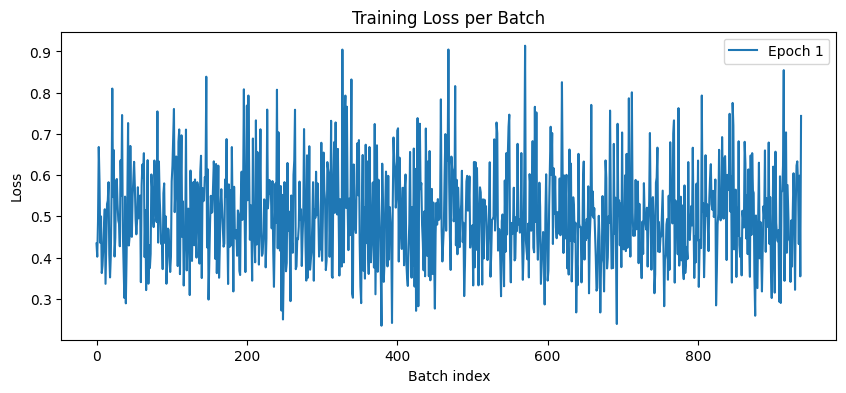

In [7]:
numEpochs = 10
allLosses = []

for epoch in range(numEpochs):
    model.train()
    runningLoss = 0.0
    batchLosses = []

    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        val = loss.item()
        runningLoss += val
        batchLosses.append(val)

    epochLoss = runningLoss / len(trainLoader)
    allLosses.append(batchLosses)
    scheduler.step(epochLoss)

    print(f"Epoch {epoch+1}/{numEpochs}, Loss: {epochLoss:.4f}")

print("Training complete.")

plt.figure(figsize=(10, 4))
plt.plot(allLosses[0], label="Epoch 1")
plt.xlabel("Batch index")
plt.ylabel("Loss")
plt.title("Training Loss per Batch")
plt.legend()
plt.show()

<br>

## Part 3: Results Evaluation